In [1]:
import glob
import ast
import json
import numpy as np
import pandas as pd
from collections import OrderedDict
from pyplot_helper import plot_confusion_matrix

In [2]:
# ADAPT: adapt the path to the best models
results = "results/stm_v2_best_models/"

# ADAPT: adapt the path to the domain
run = "overall_dr_0.5_lstm_hs_768_lr_0.005"

domains = ["overall", "Agriculture", "Astronomy", "Biology", "Chemistry", "Computer_Science", "Earth_Science", "Engineering", "Materials_Science", "Mathematics", "Medicine"]

folds = 0
rows = []
confusion_matrices = OrderedDict()
labels = None
for m in glob.glob(f"{results}/{run}/**/metrics_scienceie2017.json"):
    with open(m, "r", encoding="utf-8") as m_f:
        s = m_f.read()
        s = s.replace("'", '"')
        metrics = json.loads(s)    
        folds += 1
        
    print(m)
    
    for d in metrics:
        domain = d["domain"]
        
        print(domain)
        if domain not in confusion_matrices:
            confusion_matrices[domain] = {
                "test": [], 
                "dev": []
            }        
        
        confusion_matrices[domain]["test"].append(np.array(d["test_token_based"]["confusion_abs"])) 
        confusion_matrices[domain]["dev"].append(np.array(d["dev_token_based"]["confusion_abs"]))
        labels = d["dev_token_based"]["labels"]
        # entitity based
        for split in ["dev", "test"]:
            for label in d[split].keys():                                    
                for metric in ["precision", "recall", "f1-score"]:
                    rows.append([domain, label, split, "entity-based", metric, d[split][label][metric]])
        # span only
        for split in ["dev_span", "test_span"]:
            for label in d[split].keys():                                    
                for metric in ["precision", "recall", "f1-score"]:
                    rows.append([domain, label, split, "span-only", metric, d[split][label][metric]])                    
        
        # token based
        for split in ["dev", "test"]:            
            for metric in ["accuracy", "weighted-f1", "macro-f1", "micro-f1"]:
                rows.append([domain, "overall", split, "token-based",  metric, d[split + "_token_based"][metric]])         
        
        rows.append([domain, "overall", "dev_span", "span-only",  "accuracy", d["dev_span_accuracy"]])         
        rows.append([domain, "overall", "test_span", "span-only",  "accuracy", d["test_span_accuracy"]])         
                
        rows.append([domain, "overall", "dev", "allennlp",  "f1-score", d["dev_f1_allennlp"]])
        rows.append([domain, "overall", "test", "allennlp",  "f1-score", d["test_f1_allennlp"]])                     
                    
print(f'folds: {folds}')        


/data/science-ner-classifier/results/stm_v2_best_models//overall_dr_0.5_lstm_hs_768_lr_0.005/stm_fold_1_dr_0.5_lstm_hs_768_lr_0.005/metrics_scienceie2017_3.json
overall
Agriculture
Astronomy
Biology
Chemistry
Computer_Science
Earth_Science
Engineering
Materials_Science
Mathematics
Medicine
/data/science-ner-classifier/results/stm_v2_best_models//overall_dr_0.5_lstm_hs_768_lr_0.005/stm_fold_4_dr_0.5_lstm_hs_768_lr_0.005/metrics_scienceie2017_3.json
overall
Agriculture
Astronomy
Biology
Chemistry
Computer_Science
Earth_Science
Engineering
Materials_Science
Mathematics
Medicine
/data/science-ner-classifier/results/stm_v2_best_models//overall_dr_0.5_lstm_hs_768_lr_0.005/stm_fold_2_dr_0.5_lstm_hs_768_lr_0.005/metrics_scienceie2017_3.json
overall
Agriculture
Astronomy
Biology
Chemistry
Computer_Science
Earth_Science
Engineering
Materials_Science
Mathematics
Medicine
/data/science-ner-classifier/results/stm_v2_best_models//overall_dr_0.5_lstm_hs_768_lr_0.005/stm_fold_3_dr_0.5_lstm_hs_768_lr_0

In [3]:
confusion_matrices

OrderedDict([('overall', {'test': [array([[ 613,   14,    5,   32,   33],
                       [ 162,  961,   25,   64,   49],
                       [  41,   55,  188,   25,    2],
                       [ 155,   28,   55,  583,   41],
                       [ 120,   51,   18,   90, 2026]]),
                array([[ 566,  112,    0,  115,   47],
                       [  84, 1039,    8,   59,   36],
                       [  22,  110,  144,   59,   10],
                       [  92,  105,   18,  801,   52],
                       [  96,   68,   11,  168, 2364]]),
                array([[ 603,   28,   13,   79,   51],
                       [  99,  921,   35,   33,   49],
                       [  12,   48,  122,   48,    3],
                       [  83,   38,   52,  528,   53],
                       [  58,   42,   27,  103, 1924]]),
                array([[ 552,   51,    0,   67,   43],
                       [  80,  966,    0,   46,   47],
                       [  10,   98,   67

/home/bracka/workspace/science-ner-classifier/pyplot_helper.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/home/bracka/workspace/science-ner-classifier/pyplot_helper.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


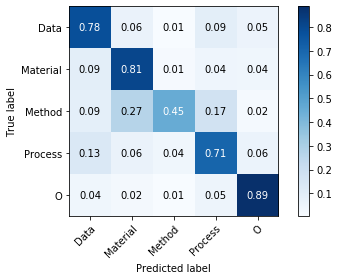

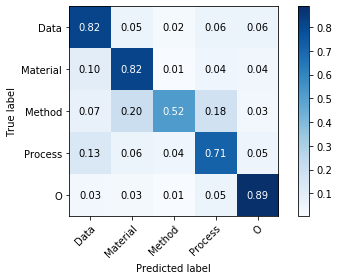

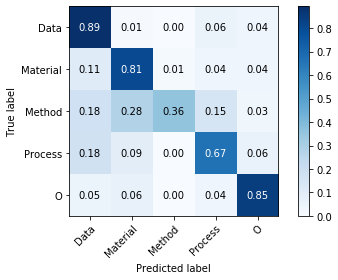

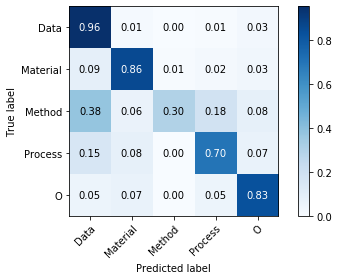

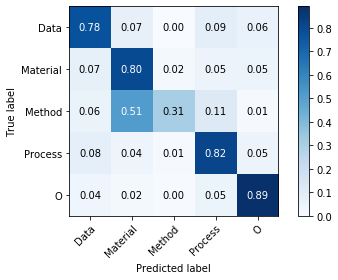

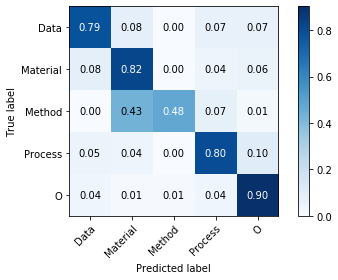

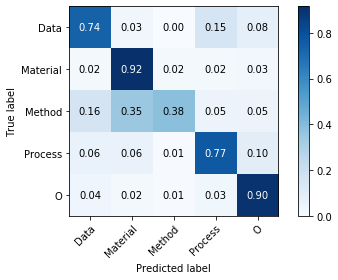

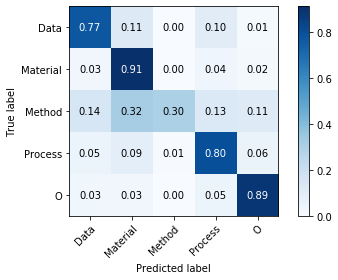

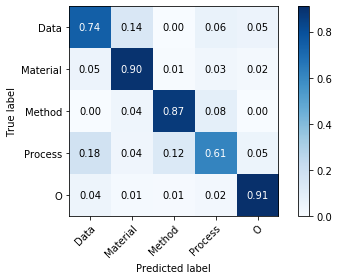

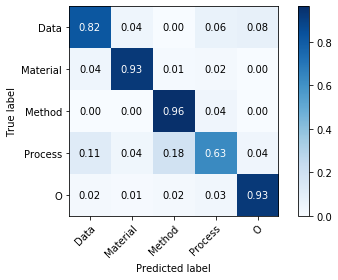

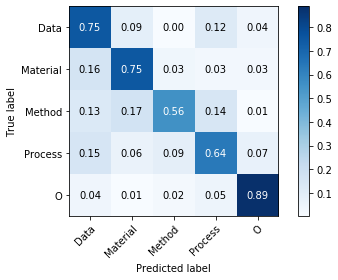

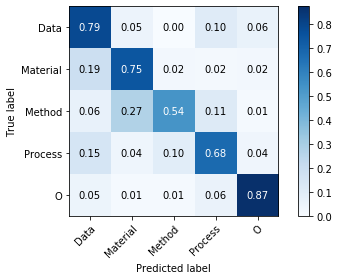

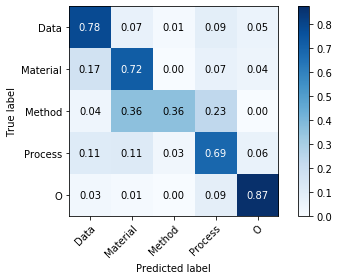

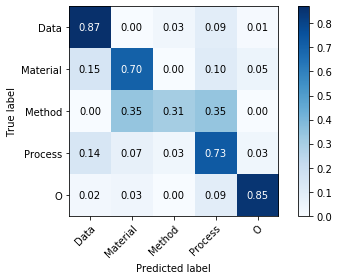

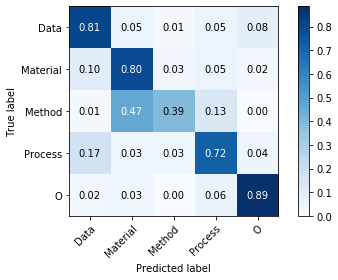

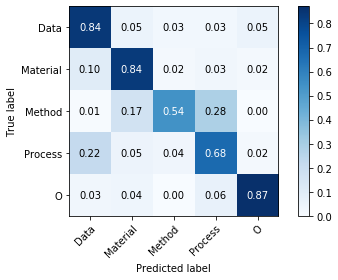

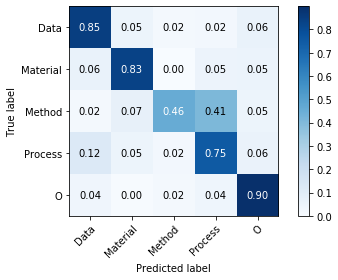

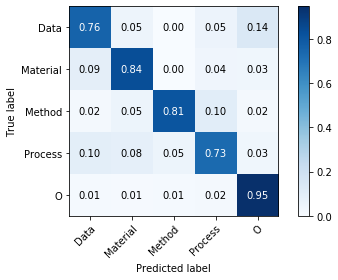

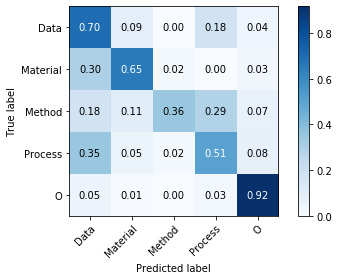

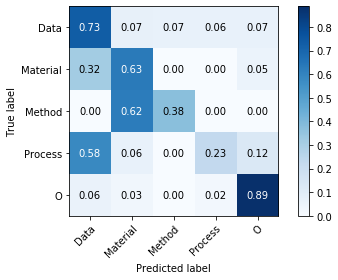

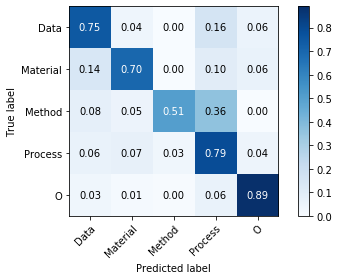

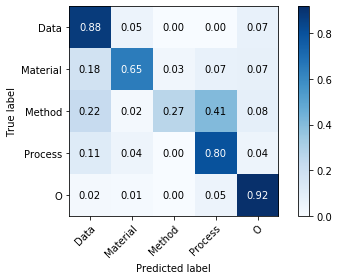

In [4]:
#sum confusion matrices and plot them
for domain in domains:
    for split in confusion_matrices[domain]:
        m = np.zeros((5, 5), dtype=int)
        for i in confusion_matrices[domain][split]:
            m = m + i
        confusion_matrices[domain][split] = m
        #title = f'{domain} ({split})'
        filename = f'{results}/{run}/{domain}_{split}.pdf'
        plot_confusion_matrix(m, labels, normalize=True, filename=filename, file_format="pdf")



In [5]:
def mean_std(vals):
    mean = np.mean(vals)
    std = np.std(vals)
    #return f'{round(mean, 2)} (+/-{round(std, 2)})'
    return f'{round(mean, 2)}'

df = pd.DataFrame(rows, columns=["domain", "label", "split", "eval-method", "metric", "value"])
df = pd.pivot_table(df,index=["split", "eval-method", "metric"], values=["value"], columns=["domain", "label"], aggfunc=[mean_std])



df.to_csv(f"{results}/{run}/results.csv")
df

mean_std                             \
                                         value                              
domain                             Agriculture                              
label                                     Data KEYPHRASE-NOTYPES Material   
split     eval-method  metric                                               
dev       allennlp     f1-score            NaN               NaN      NaN   
          entity-based f1-score           0.71               NaN     0.74   
                       precision          0.64               NaN     0.71   
                       recall             0.80               NaN     0.78   
          token-based  accuracy            NaN               NaN      NaN   
                       macro-f1            NaN               NaN      NaN   
                       micro-f1            NaN               NaN      NaN   
                       weighted-f1         NaN               NaN      NaN   
dev_span  span-only    accuracy            NaN               NaN      NaN   
                       f1-score            NaN              0.78      NaN   
                       precision           NaN              0.75      NaN   
                       recall              NaN              0.81      NaN   
test      allennlp     f1-score            NaN               NaN      NaN   
          entity-based f1-score           0.65               NaN     0.69   
                       precision          0.63               NaN     0.65   
                       recall             0.69               NaN     0.75   
          token-based  accuracy            NaN               NaN      NaN   
                       macro-f1            NaN               NaN      NaN   
                       micro-f1            NaN               NaN      NaN   
                       weighted-f1         NaN               NaN      NaN   
test_span span-only    accuracy            NaN               NaN      NaN   
                       f1-score            NaN              0.79      NaN   
                       precision           NaN              0.77      NaN   
                       recall              NaN              0.81      NaN   

                                                                     \
                                                                      
domain                                                    Astronomy   
label                              Method Process overall      Data   
split     eval-method  metric                                         
dev       allennlp     f1-score       NaN     NaN    0.69       NaN   
          entity-based f1-score      0.44    0.70    0.71      0.64   
                       precision     0.67    0.72    0.69      0.67   
                       recall        0.33    0.68    0.73      0.62   
          token-based  accuracy       NaN     NaN    0.82       NaN   
                       macro-f1       NaN     NaN    0.72       NaN   
                       micro-f1       NaN     NaN    0.82       NaN   
                       weighted-f1    NaN     NaN    0.82       NaN   
dev_span  span-only    accuracy       NaN     NaN    0.64       NaN   
                       f1-score       NaN     NaN    0.78       NaN   
                       precision      NaN     NaN    0.75       NaN   
                       recall         NaN     NaN    0.81       NaN   
test      allennlp     f1-score       NaN     NaN    0.66       NaN   
          entity-based f1-score      0.66    0.67    0.68      0.61   
                       precision     0.75    0.68    0.66      0.63   
                       recall        0.66    0.67    0.70      0.60   
          token-based  accuracy       NaN     NaN    0.79       NaN   
                       macro-f1       NaN     NaN    0.71       NaN   
                       micro-f1       NaN     NaN    0.79       NaN   
                       weighted-f1    NaN     NaN    0.79       NaN   
test_span span-only    accura